In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook
from pyha import *
from pyha.cores import *
from pyha.cores.util import *
import scipy
from scipy import signal
import warnings
warnings.filterwarnings('ignore') # yolo!
import numpy as np


import matplotlib.pyplot as plt
def make_freq_response(samples):
    A = np.fft.fft(samples, len(samples) * 8) / (len(samples)/2.0)
    freq = np.linspace(-1, 1, len(A))
    response = 20 * np.log10(np.abs(np.fft.fftshift(A / abs(A).max())))
    return freq, response

# GitHub cannot display the Table of Contents!

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

# Info
Implements a windowing function for complex signal. Coefficients are stored as constants (LUTs). Storing ~8 bit coefficients in LUTS is acutally pretty good, apparantly there is alot of sharing done by the synthesizer.

## Recommended paremeters
Hanning window with 8 bit coefficients.

# Examples

## Hamming 8-bit

INFO:sim:Running "MODEL" simulation...
INFO:sim:Running "PYHA" simulation...
100%|██████████| 512/512 [00:00<00:00, 39376.64it/s]
INFO:sim:Flushing the pipeline to collect 512 valid samples (currently have 511)
INFO:sim:Hardware delay is 1


<IPython.core.display.Javascript object>


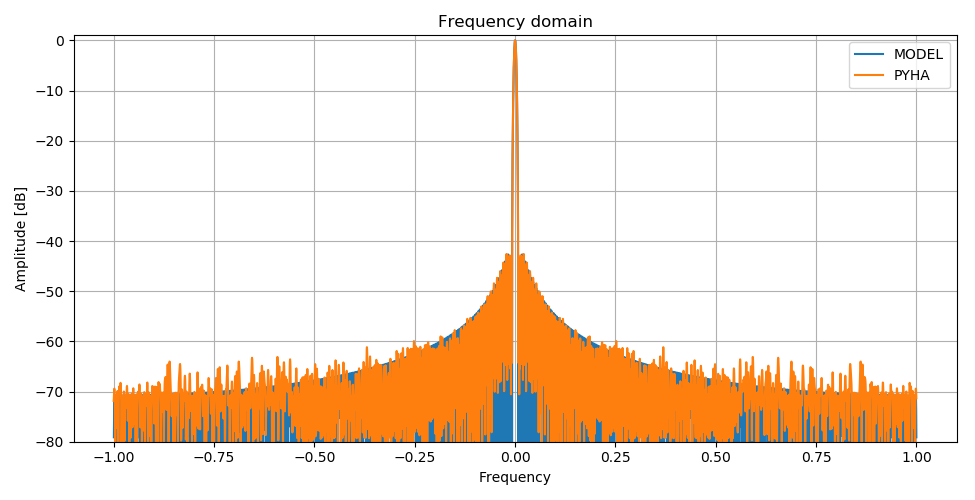

In [8]:
fft_size = 512
input_signal = [1.0 + 1.0j] * fft_size
dut = Windower(fft_size, window='hamming', coefficient_bits=8)
sim = Simulator(dut).run(input_signal)

plt.figure(figsize = (9.75, 5))
plt.title('Frequency domain')
plt.plot(*make_freq_response(sim.out[0][0][:fft_size]), label='MODEL')
plt.plot(*make_freq_response(sim.out[1][0][:fft_size]), label='PYHA')

plt.ylabel('Amplitude [dB]')
plt.xlabel('Frequency')
plt.ylim([-80, 1])
show_plot()

## Hanning 8-bit

INFO:sim:Running "MODEL" simulation...
INFO:sim:Running "PYHA" simulation...
100%|██████████| 512/512 [00:00<00:00, 39827.96it/s]
INFO:sim:Flushing the pipeline to collect 512 valid samples (currently have 511)
INFO:sim:Hardware delay is 1


<IPython.core.display.Javascript object>


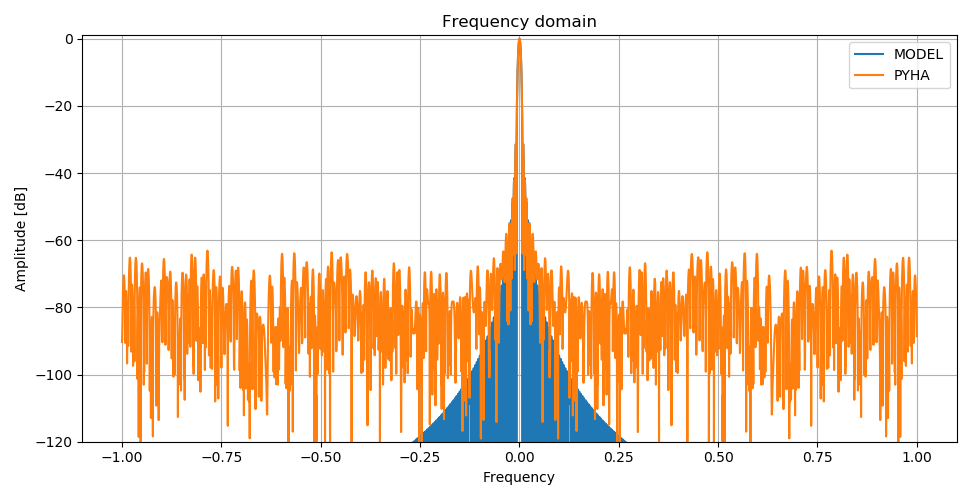

In [4]:
fft_size = 512
input_signal = [1.0 + 1.0j] * fft_size

dut = Windower(fft_size, window='hanning', coefficient_bits=8)
sim = Simulator(dut).run(input_signal)

plt.figure(figsize = (9.75, 5))
plt.title('Frequency domain')
plt.plot(*make_freq_response(sim.out[0][0][:fft_size]), label='MODEL')
plt.plot(*make_freq_response(sim.out[1][0][:fft_size]), label='PYHA')

plt.ylabel('Amplitude [dB]')
plt.xlabel('Frequency')
plt.ylim([-120, 1])
show_plot()

# Conversion to VHDL and RTL/NETLIST simulations

In [6]:
# Pyha design can be converted to VHDL after the PYHA simulation has been ran
# VHDL sources can be used to run the RTL simulation, in addition NETLIST simulation is supported (after Quartus mapper)
# Pyha automatically manages everything needed if you specify the 'RTL', 'NETLIST' flags.
output_dir = '~/Documents/pyha_output'
fft_size=512
input_signal = (np.random.normal(size=fft_size) + np.random.normal(size=fft_size) * 1j) * 0.25
dut = Windower(fft_size, coefficient_bits=18)
vhdl_sim = Simulator(dut, output_dir=output_dir, extra_simulations=['RTL', 'NETLIST']).run(input_signal)
vhdl_sim.assert_equal(atol=1e-5, rtol=1e-5)

INFO:sim:Simulaton needs to support conversion to VHDL -> major slowdown
INFO:sim:Running "MODEL" simulation...
INFO:sim:Running "PYHA" simulation...
100%|██████████| 512/512 [00:00<00:00, 10107.33it/s]
INFO:sim:Flushing the pipeline to collect 512 valid samples (currently have 511)
INFO:sim:Hardware delay is 1
INFO:conversion:Creating top.vhd ...
INFO:conversion:DataValid to VHDL ...
INFO:conversion:Windower to VHDL ...
INFO:sim:Running "RTL" simulation...
loading VPI module '/cocotb/build/libs/x86_64/libvpi.so'
VPI module loaded!
100%|##########| 513/513 [00:00<00:00, 3287.20it/s]

INFO:sim:Running "NETLIST" simulation...
INFO:synth:Running quartus_map quartus_project...
INFO:synth:Running quartus_eda quartus_project...
loading VPI module '/cocotb/build/libs/x86_64/libvpi.so'
VPI module loaded!
100%|##########| 513/513 [00:00<00:00, 768.29it/s]

INFO:sim:Testing that PYHA and MODEL are close(atol=1e-05, rtol=1e-05)
INFO:sim:Testing that RTL is *exactly* equal to PYHA
INFO:sim:Testing

# Synthesis:  resource usage and Fmax

In [7]:
print(vhdl_sim.quartus.get_resource_usage('fit'))
print(vhdl_sim.quartus.get_fmax())

INFO:synth:Running quartus_fit quartus_project...
INFO:synth:Running quartus_sta -t script.tcl...


Family : Cyclone IV E
Device : EP4CE40F23C8
Timing Models : Final
Total logic elements : 607 / 39,600 ( 2 % )
    Total combinational functions : 607 / 39,600 ( 2 % )
    Dedicated logic registers : 63 / 39,600 ( < 1 % )
Total registers : 63
Total pins : 76 / 329 ( 23 % )
Total virtual pins : 0
Total memory bits : 0 / 1,161,216 ( 0 % )
Embedded Multiplier 9-bit elements : 4 / 232 ( 2 % )
Total PLLs : 0 / 4 ( 0 % )

+------------------------------------------------+
; Fmax Summary                                   ;
+----------+-----------------+------------+------+
; Fmax     ; Restricted Fmax ; Clock Name ; Note ;
+----------+-----------------+------------+------+
; 97.9 MHz ; 97.9 MHz        ; clk        ;      ;
+----------+-----------------+------------+------+
This panel reports FMAX for every clock in the design, regardless of the user-specified clock periods.  FMAX is only computed for paths where the source and destination registers or ports are driven by the same clock.  Paths